Face Mask Detection Images Dataset
- **Nama:** RAHMAT HIDAYAT
- **Email:** mc013d5y1559@student.devacademy.id
- **ID Dicoding:** MC013D5Y1559

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install kaggle
!pip install tensorflow
!pip install tensorflowjs


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from PIL import Image


/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


In [ ]:
# Aktifkan Mixed Precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')


In [ ]:
import shutil

# Pindahkan ke direktori yang benar
os.makedirs("/root/.kaggle", exist_ok=True)

# Check if the file already exists in the destination
if not os.path.exists("/root/.kaggle/kaggle.json"):
    shutil.move("kaggle.json", "/root/.kaggle/")
else:
    print("kaggle.json already exists in the destination directory.")

# Ubah izin file agar tidak bisa diakses oleh orang lain
os.chmod("/root/.kaggle/kaggle.json", 600)


kaggle.json already exists in the destination directory.


In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset


Dataset URL: https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset
License(s): CC0-1.0


In [ ]:
import zipfile

# Ekstrak dataset
with zipfile.ZipFile("face-mask-12k-images-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("/content/")


## Data Preparation

### Data Loading

In [ ]:
# 1. Data Preparation & Loading
dataset_path = "/content/Face Mask Dataset/"
train_dir = os.path.join(dataset_path, "Train")
val_dir = os.path.join(dataset_path, "Validation")
test_dir = os.path.join(dataset_path, "Test")

# Melihat jumlah gambar dan resolusinya
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(train_dir)


WithoutMask: 5000
- (84, 84)
- (116, 116)
- (61, 61)
- (126, 126)
- (57, 57)
- (122, 122)
- (117, 117)
- (94, 94)
- (58, 58)
- (90, 90)
- (150, 150)
- (127, 127)
- (91, 91)
- (123, 123)
- (59, 59)
- (124, 124)
- (101, 101)
- (156, 156)
- (65, 65)
- (97, 97)
- (92, 92)
- (33, 33)
- (88, 88)
- (98, 98)
- (125, 125)
- (70, 70)
- (29, 29)
- (121, 121)
- (66, 66)
- (131, 131)
- (72, 72)
- (99, 99)
- (44, 44)
- (95, 95)
- (132, 132)
- (96, 96)
- (128, 128)
- (69, 69)
- (129, 129)
- (106, 106)
- (102, 102)
- (47, 47)
- (139, 139)
- (134, 134)
- (103, 103)
- (80, 80)
- (135, 135)
- (130, 130)
- (75, 75)
- (76, 76)
- (71, 71)
- (136, 136)
- (108, 108)
- (67, 67)
- (77, 77)
- (104, 104)
- (114, 114)
- (100, 100)
- (110, 110)
- (105, 105)
- (82, 82)
- (51, 51)
- (78, 78)
- (133, 133)
- (143, 143)
- (138, 138)
- (115, 115)
- (74, 74)
- (79, 79)
- (56, 56)
- (111, 111)
- (107, 107)
- (52, 52)
- (112, 112)
- (89, 89)
- (53, 53)
- (85, 85)
- (30, 30)
- (145, 145)
- (81, 81)
- (26, 26)
- (86, 86)
- (1

### Data Preprocessing

#### Split Dataset

In [ ]:
# 2. Data Preprocessing & Augmentation
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


## Modelling

In [ ]:
# 3. Modeling
num_classes = len(train_data.class_indices)
model = models.Sequential([
    Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 4. Implementasi Callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# 5. Training Model
epochs = 30
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,245,186 (84.86 MB)

 Trainable params: 22,245,186 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 151s 437ms/step - accuracy: 0.7599 - loss: 1.6197 - val_accuracy: 0.9688 - val_loss: 0.1117 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 119s 381ms/step - accuracy: 0.9347 - loss: 0.1794 - val_accuracy: 0.9588 - val_loss: 0.1062 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 119s 381ms/step - accuracy: 0.9344 - loss: 0.1681 - val_accuracy: 0.9650 - val_loss: 0.1050 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9435 - loss: 0.1690 - val_accuracy: 0.9762 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9501 - loss: 0.1467 - val_accuracy: 0.9675 - val_loss: 0.0968 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 119s 381ms/step - accuracy: 0.9503 - loss: 0.1404 - val_accuracy: 0.9688 - val_loss: 0.0823 - learning_rate: 0.0010
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accura

## Evaluasi dan Visualisasi

313/313 ━━━━━━━━━━━━━━━━━━━━ 114s 363ms/step - accuracy: 0.9919 - loss: 0.0244
Training Accuracy: 99.12%
Training Loss: 0.0273
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9931 - loss: 0.0154
Validation Accuracy: 99.37%
Validation Loss: 0.0126
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9879 - loss: 0.0248
Testing Accuracy: 99.19%
Testing Loss: 0.0212


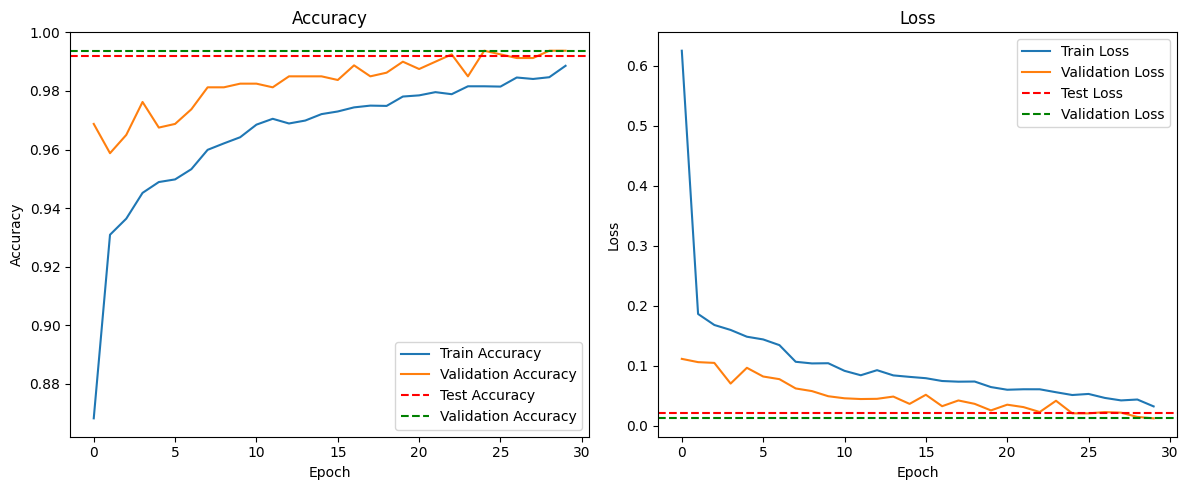

In [ ]:
# 6. Evaluasi Model
# Evaluasi pada training set
train_loss, train_acc = model.evaluate(train_data)
print(f"Training Accuracy: {train_acc:.2%}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluasi pada validation set
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2%}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluasi pada testing set
test_loss, test_acc = model.evaluate(test_data)
print(f"Testing Accuracy: {test_acc:.2%}")
print(f"Testing Loss: {test_loss:.4f}")

# 7. Visualisasi Akurasi dan Loss
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Changed 'validation_accuracy' to 'val_accuracy'
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.axhline(y=val_acc, color='g', linestyle='--', label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss') # Changed 'validation_loss' to 'val_loss'
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.axhline(y=val_loss, color='g', linestyle='--', label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

## Konversi Model

In [ ]:
# Pastikan direktori penyimpanan ada
os.makedirs("tfjs_model", exist_ok=True)
os.makedirs("tflite", exist_ok=True)
os.makedirs("saved_model", exist_ok=True)

# Simpan model dalam format SavedModel
model.export("saved_model")

# Konversi ke TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

try:
    tflite_model = converter.convert()
    with open("tflite/model.tflite", "wb") as f:
        f.write(tflite_model)
    print("Konversi ke TFLite berhasil!")
except Exception as e:
    print(f"Gagal mengonversi ke TFLite: {e}")

# Simpan label untuk model TF-Lite
class_labels = list(train_data.class_indices.keys())
with open("tflite/label.txt", "w") as f:
    for label in class_labels:
        f.write(label + "\n")

# Konversi ke TensorFlow.js
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model

import subprocess

try:
    subprocess.run([
        "tensorflowjs_converter",
        "--input_format=tf_saved_model",
        "--output_format=tfjs_graph_model",
        "saved_model",
        "tfjs_model"
    ], check=True)
    print("Konversi ke TensorFlow.js berhasil!")
except subprocess.CalledProcessError as e:
    print(f"Gagal mengonversi ke TensorFlow.js: {e}")

print("Proses konversi selesai!")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float16, name=None)
Captures:
  139193102746064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139193102746832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139193102748944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139193102747792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139193102748368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139193102749712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139193102747600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139193102750672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139193102749328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139193102752016: TensorSpec(shape=(), dtype=tf.resource, name=None)
Konversi ke TFLite be

## Inference (Optional)

In [ ]:
# 9. Inference (Menggunakan TF-Lite)
# Label kelas
class_labels = ["With Mask", "Without Mask"]

def predict_tflite(image_path, model_path='tflite/model.tflite'):
    # Load model TFLite
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Ambil detail input & output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Ambil ukuran input model
    img_height, img_width = input_details[0]['shape'][1:3]

    # Load dan preprocess gambar
    img = Image.open(image_path).resize((img_height, img_width))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

    # Set input model
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    # Ambil hasil prediksi
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]

    # Dapatkan kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class] * 100

    # Tampilkan hasil prediksi
    print(f"\n=== HASIL PREDIKSI ===")
    for i, prob in enumerate(predictions):
        print(f"{class_labels[i]}: {prob:.4f}")

    print(f"\nKelas Terpilih: {class_labels[predicted_class]} ({confidence:.2f}%)")

    return class_labels[predicted_class], confidence

# Path gambar yang akan diuji
image_path = "/content/sample.jpeg"

# Jalankan prediksi
predicted_label, confidence = predict_tflite(image_path)



=== HASIL PREDIKSI ===
With Mask: 1.0000
Without Mask: 0.0000

Kelas Terpilih: With Mask (100.00%)
